# 如何使用 ReAct Agent 返回结构化输出

> 参考资料：https://langchain-ai.github.io/langgraph/how-tos/react-agent-structured-output/

您可能希望您的 Agent 以结构化格式返回其输出。例如，如果 Agent 返回的输出被某些其他下游软件使用，您可能希望每次调用代理时输出都采用相同的结构化格式，以确保一致性。

这里将介绍两种强制使用工具调用（Tool Calling）的 Agent 结构其输出的不同选项。我们将使用一个基本的 ReAct Agent（一个模型节点和一个工具调用节点）以及一个在最后的节点，该节点将格式化用户响应。这两种选项将使用与下面图表相同的图结构，但在内部机制上有所不同。

![](https://s2.loli.net/2024/09/19/GMUi9ZJAjupv6Cd.png)

## 选项 1：将输出绑定为工具

![](https://s2.loli.net/2024/09/19/cIHJgtGD2nz9asi.png)

您可以通过将您希望使用的输出作为附加工具绑定到 `agent` 节点来强制您的工具调用代理具有结构化输出。

与基本 ReAct 代理不同，在这种情况下，`agent` 节点不是在 `tools` 和 `END` 之间进行选择，而是选择它调用的特定工具。在这种情况下，预期的流程是 `agent` 节点中的 LLM 首先选择动作工具，在接收到动作工具输出后，将调用响应工具，然后将其路由到仅对 `agent` 节点工具调用中的参数进行结构化的 `respond` 节点。

### 优点和缺点

这种格式的优点是只需要一个 LLM，因此可以节省金钱和延迟。

这种选择的缺点是并不能保证当需要时，单个 LLM 会调用正确的工具。当我们使用 `bind_tools` 时，我们可以通过将 `tool_choice` 设置为 `any` 来帮助 LLM，这会强制 LLM 在每一轮至少选择一个工具，但这远非万无一失的策略。此外，另一个缺点是 Agent 可能会调用多个工具，因此我们需要在我们的路由函数中明确检查这一点（或者如果我们使用 OpenAI，我们可以设置 `parallell_tool_calling=False` 以确保一次只调用一个工具）。

> 我们将在本教程中使用一个工具来查找天气，并将返回一个结构化的天气响应给用户。

In [11]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

class WeatherResponse(BaseModel):
    """Respond to the user with this"""
    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(description="The direction of the wind in abbreviated form")
    wind_speed: float = Field(description="The speed of the wind in km/h")

# Inherit 'messages' key from MessagesState, which is a list of chat messages 
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: WeatherResponse

@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It is cloudy in NYC, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "sf":
        return "It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")
    
model = ChatOpenAI(model="gpt-4o-mini")
    
model_with_tools = model.bind_tools([get_weather])
model_with_structured_output = model.with_structured_output(WeatherResponse)

In [2]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# Force the model to use tools by passing tool_choice="any"    
model_with_response_tool = model.bind_tools([get_weather, WeatherResponse],tool_choice="any")

# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_response_tool.invoke(state['messages'])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function that responds to the user
def respond(state: AgentState):
    # Construct the final answer from the arguments of the last tool call
    response = WeatherResponse(**state['messages'][-1].tool_calls[0]['args'])
    # We return the final answer
    return {"final_response": response}

# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if len(last_message.tool_calls) == 1 and last_message.tool_calls[0]['name'] == "WeatherResponse":
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

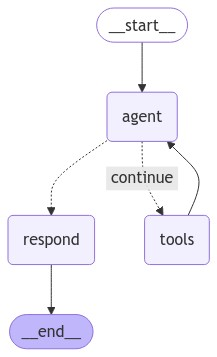

In [3]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [4]:
graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})['final_response']

WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=3.0)

👆 LangSmith Trace: https://smith.langchain.com/public/eecbc1f6-a063-492f-9384-5e20597cf2a3/r

## 选项 2：使用第二个 LLM 来强制输出

![](https://s2.loli.net/2024/09/19/UfEnFlDmZ9VzdBP.png)

在这种情况下，您将像平常一样定义一个基本的 ReAct Agent，但不是让 `agent` 节点在 `tools` 节点和结束对话之间选择，而是让 `agent` 节点在 `tools` 节点和 `respond` 节点之间选择。 `respond` 节点将包含一个使用结构化输出的第二个 LLM，一旦被调用，将直接返回给用户。

您可以将这种方法视为在响应用户之前的一个额外步骤的基本 ReAct。

### 优点和缺点

这种方法的好处是它保证了结构化的输出（只要 `.with_structured_output` 与 LLM 按预期工作）。

使用这种方法的缺点是需要在响应用户之前进行额外的 LLM 调用，这可能会增加成本以及延迟。此外，由于没有向 `agent` 节点 LLM 提供关于所需输出模式的信息，存在风险，即 `agent` LLM 将无法调用回答正确输出模式所需的正确工具。

In [12]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_tools.invoke(state['messages'])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function that responds to the user
def respond(state: AgentState):
    # We call the model with structured output in order to return the same format to the user every time
    # state['messages'][-2] is the last ToolMessage in the convo, which we convert to a HumanMessage for the model to use
    # We could also pass the entire chat history, but this saves tokens since all we care to structure is the output of the tool
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-2].content)])
    # We return the final answer
    return {"final_response": response}

# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

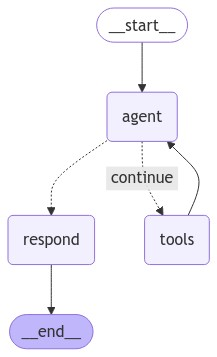

In [7]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [13]:
graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})['final_response']

WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=3.0)

👆 LangSmith Trace: https://smith.langchain.com/public/ee20b5dd-c7b5-4832-a271-15fd1642a21d/r

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e6124301-0a3c-4c43-a70b-884a597351fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>